In [1]:

import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy
#import tensorflow_io as tfio

## Load Yamnet model

In [2]:

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)



## Data Preprocessing

In [3]:

def data_balance(path_to_subset):

    for folder in (os.listdir(path_to_subset)):
        #ingone .txt file 
        if folder.split(".")[-1]=="txt":
            pass
        else:
            print("class name :",folder)
            print(len(os.listdir(os.path.join(path_to_subset, folder))))
              
         
        
data_balance("/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild")

class name : fake
11816
class name : real
19963


In [4]:
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
    
  # Repeat the label to match the number of embeddings
  repeated_labels = tf.tile(tf.expand_dims(label, axis=0), [num_embeddings, 1])
  return (embeddings,repeated_labels)
  #return (embeddings[0],label)


def data_prepocessing(path_to_subset):

    data = []
    folder_name = []
    
    embedings_array=[]
    label_array=[]
    
    
    for folder in tqdm(os.listdir(path_to_subset)):
        
        if folder.split(".")[-1]=="txt":
            pass
            
        else:
    
          for audio in os.listdir(os.path.join(path_to_subset, folder)):
              path_to_audio = os.path.join(path_to_subset, folder,audio)
        
              sound_sample,sr=librosa.load(path_to_audio ,sr=16000)
              #dur = librosa.get_duration(y=sound_sample, sr=sr)
              #print(dur)
    
              
              wav_data_tensor = tf.convert_to_tensor(sound_sample, dtype=tf.float32)
              
              
              data.append(wav_data_tensor)
              folder_name.append(folder)
    
    #print(folder_name.count("fake"))
    #print(folder_name.count("real"))
    # Create the LabelEncoder
    lb = LabelBinarizer()
    
    # Fit and transform the labels
    binary_labels = lb.fit_transform(folder_name)
    y_one_hot = np.hstack((1 - binary_labels, binary_labels))

    label = tf.convert_to_tensor(y_one_hot, dtype=tf.int32)
    

    
    for sound_data,label2 in tqdm(zip(data,label)):
        embeddings,repeated_labels=extract_embedding(sound_data, label2)
        embedings_array.extend(embeddings)
        label_array.extend(repeated_labels)

    label = tf.convert_to_tensor(y_one_hot, dtype=tf.int32)
    print("\nClasses:", lb.classes_)
    return embedings_array,label_array,lb.classes_



In [5]:

path_to_subset= '/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild'
data,label,classes=data_prepocessing(path_to_subset)

100%|██████████| 3/3 [06:54<00:00, 138.01s/it]


11816
19963


31779it [05:03, 104.80it/s]



Classes: ['fake' 'real']


In [6]:

print("Dataset len :",len(data))
print("Dataset labels len :",len(label))

Dataset len : 266945
Dataset labels len : 266945


In [7]:

print(data[0])
print(label[0])

tf.Tensor([0.13541636 0.70084    0.31326005 ... 0.4585339  0.         0.        ], shape=(1024,), dtype=float32)
tf.Tensor([1 0], shape=(2,), dtype=int32)


## Split the data

In [8]:

# Split into training and validation sets
from sklearn.model_selection import train_test_split
# Convert TensorFlow dataset to NumPy arrays (or lists)
features = []
labels = []

for feature, label in tqdm(zip(data,label)):
    features.append(feature.numpy())
    labels.append(label.numpy())

features = np.array(features)
labels = np.array(labels)


266945it [00:09, 28866.97it/s]


In [9]:

# Split into training and test sets
X_train, X_test, Y_train, y_test = train_test_split(features, labels, test_size=0.025, random_state=42)
x_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Convert back to TensorFlow datasets if needed
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

print("len train_ds :",len(train_ds))
print("len test_ds :",len(test_ds))
print("len val_ds :",len(val_ds))

# Optionally, batch the datasets
train_ds = train_ds.cache().shuffle(500).batch(64).prefetch(tf.data.AUTOTUNE)
#test_ds = test_ds.batch(128).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

# Print the datasets to confirm
for data, label in train_ds.take(1):
    print("Train data:", data.shape)
    print("Train label:", label.shape)

#for data, label in test_ds.take(1):
 #   print("Test data:", data.shape)
 #   print("Test label:", label.shape)

for data, label in val_ds.take(1):
    print("val data:", data.shape)
    print("val label:", label.shape)

len train_ds : 260271
len test_ds : 6674
len val_ds : 52055
Train data: (64, 1024)
Train label: (64, 2)
val data: (64, 1024)
val label: (64, 2)


In [10]:
for path, label in train_ds.take(1):
    print("path:", path)
    print("Label:", label)

path: tf.Tensor(
[[0.13675289 0.40882695 0.3414886  ... 0.7316549  0.19041854 0.        ]
 [0.11227503 0.01575874 0.         ... 0.         0.         0.        ]
 [0.06765965 0.16045874 0.03227837 ... 0.23772661 0.         0.        ]
 ...
 [0.         0.43510106 0.05402669 ... 0.         0.         0.        ]
 [0.         0.14031334 0.         ... 0.         0.         0.        ]
 [0.         0.04514909 0.10291802 ... 0.0418324  0.         0.        ]], shape=(64, 1024), dtype=float32)
Label: tf.Tensor(
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]], shape=(64, 2), dtype=int32)


## Create model

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, RepeatVector, BatchNormalization, TimeDistributed, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy

### ANN

In [12]:

ann_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
], name='ann_model')


ann_model.summary()

Model: "ann_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 395,010 (1.51 MB)

 Trainable params: 395,010 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
loss = tf.keras.losses.CategoricalCrossentropy()


ann_model.compile(loss=loss,
              optimizer="adam",
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20,
                                            restore_best_weights=True,
                                           verbose=1)


# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("ann_model.keras", save_best_only=True, monitor='val_loss', verbose=1)

In [14]:

ann_history=ann_model.fit(train_ds,
                       epochs=100,
                       validation_data=val_ds,
                       callbacks=[callback,checkpoint],
                         verbose=1)

Epoch 1/100
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9217 - loss: 0.1983
Epoch 1: val_loss improved from inf to 0.14040, saving model to ann_model.keras
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9217 - loss: 0.1983 - val_accuracy: 0.9455 - val_loss: 0.1404
Epoch 2/100
4039/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9478 - loss: 0.1346
Epoch 2: val_loss improved from 0.14040 to 0.11384, saving model to ann_model.keras
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9478 - loss: 0.1346 - val_accuracy: 0.9568 - val_loss: 0.1138
Epoch 3/100
4053/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9565 - loss: 0.1159
Epoch 3: val_loss improved from 0.11384 to 0.11204, saving model to ann_model.keras
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9565 - loss: 0.1159 - val_accuracy: 0.9564 - val_loss: 0.1120
Epoch 4/100
4064/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.1036
Epoch 4: val_loss improved from 0.1120

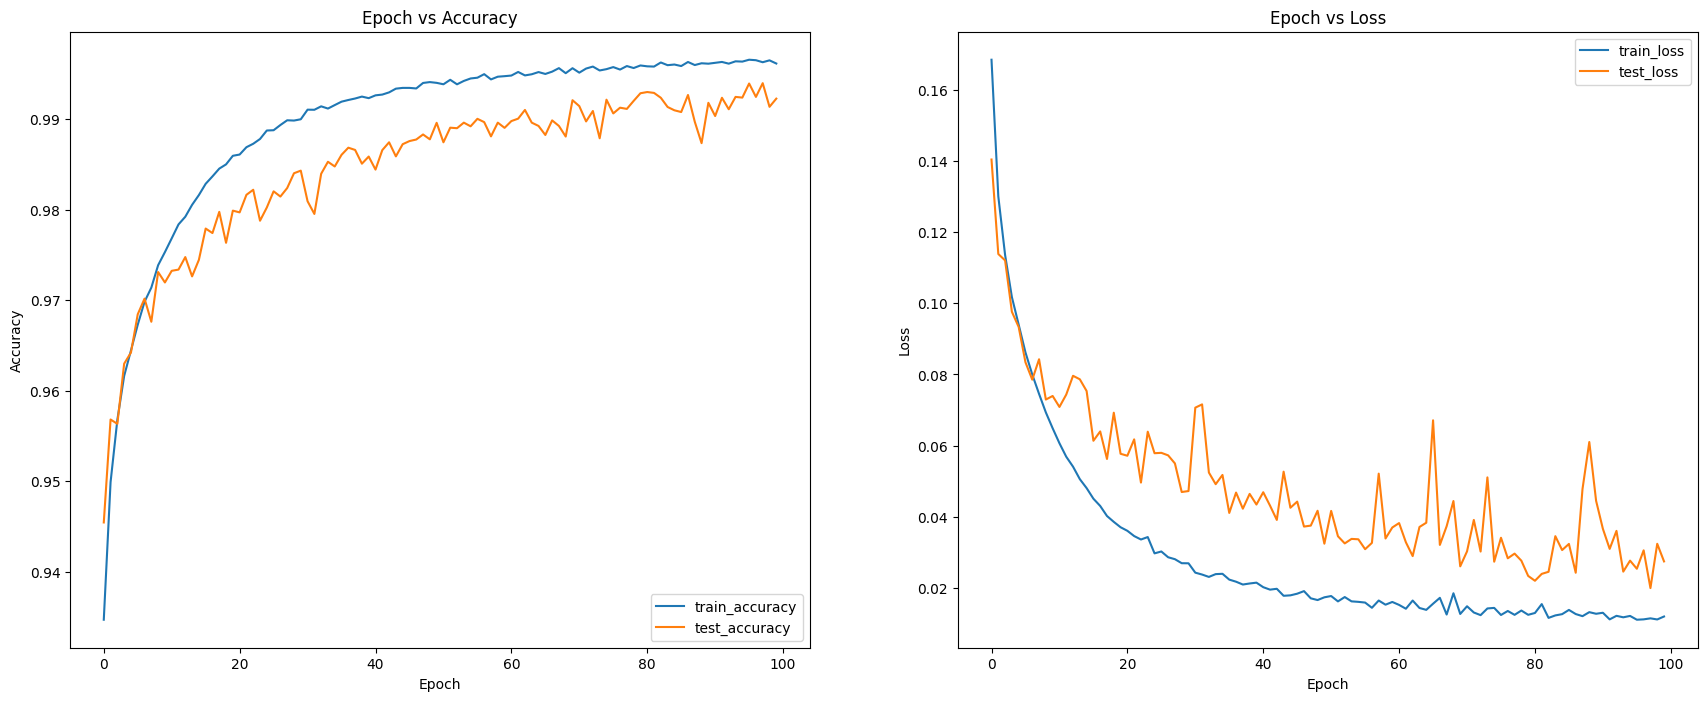

In [15]:
##
plt.figure(figsize=(21, 8))
plt.subplot(1, 2, 1)
plt.plot(ann_history.history['accuracy'], label='train_accuracy')
plt.plot(ann_history.history['val_accuracy'], label='test_accuracy')
plt.title("Epoch vs Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(ann_history.history["loss"], label='train_loss')
plt.plot(ann_history.history["val_loss"], label='test_loss')
plt.title("Epoch vs Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### CNN1D

In [22]:

def cnn_model():
    model = Sequential()
    
    # First Bidirectional LSTM layer with return_sequences=True to maintain 3D output
    model.add(Conv1D(filters=32, kernel_size=3,padding='same',strides=1, activation='relu', input_shape=(1024, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    #model.add(Conv1D(filters=64, kernel_size=3,strides=1, activation='relu'))
    #model.add(Conv1D(filters=128, kernel_size=3,strides=1, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    
    #model.add(Conv1D(filters=256, kernel_size=3,strides=1, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Dropout(0.2))
    
    model.add(Flatten())
    #model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))
    
    model.summary()

    return model

cnn_model=cnn_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1024, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 512, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,392,450 (32.01 MB)

 Trainable params: 8,391,362 (32.01 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [23]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


loss = tf.keras.losses.CategoricalCrossentropy()

cnn_model.compile(loss=loss,
              optimizer="adam",
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20,
                                            restore_best_weights=True,
                                            verbose=1)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("cnn_model.keras", save_best_only=True, monitor='val_loss', verbose=1)

In [24]:

cnn_history=cnn_model.fit(train_ds,
                       epochs=100,
                       validation_data=val_ds,
                       callbacks=[callback,checkpoint],
                          verbose=1)

Epoch 1/100
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9060 - loss: 0.2493
Epoch 1: val_loss improved from inf to 0.17736, saving model to cnn_model.keras
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.9060 - loss: 0.2493 - val_accuracy: 0.9349 - val_loss: 0.1774
Epoch 2/100
4063/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9291 - loss: 0.1856
Epoch 2: val_loss improved from 0.17736 to 0.14676, saving model to cnn_model.keras
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.9291 - loss: 0.1856 - val_accuracy: 0.9440 - val_loss: 0.1468
Epoch 3/100
4062/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9348 - loss: 0.1712
Epoch 3: val_loss did not improve from 0.14676
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.9348 - loss: 0.1712 - val_accuracy: 0.9452 - val_loss: 0.1487
Epoch 4/100
4066/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9393 - loss: 0.1606
Epoch 4: val_loss improved from 0.14676 to 0.12689, saving model to cnn_

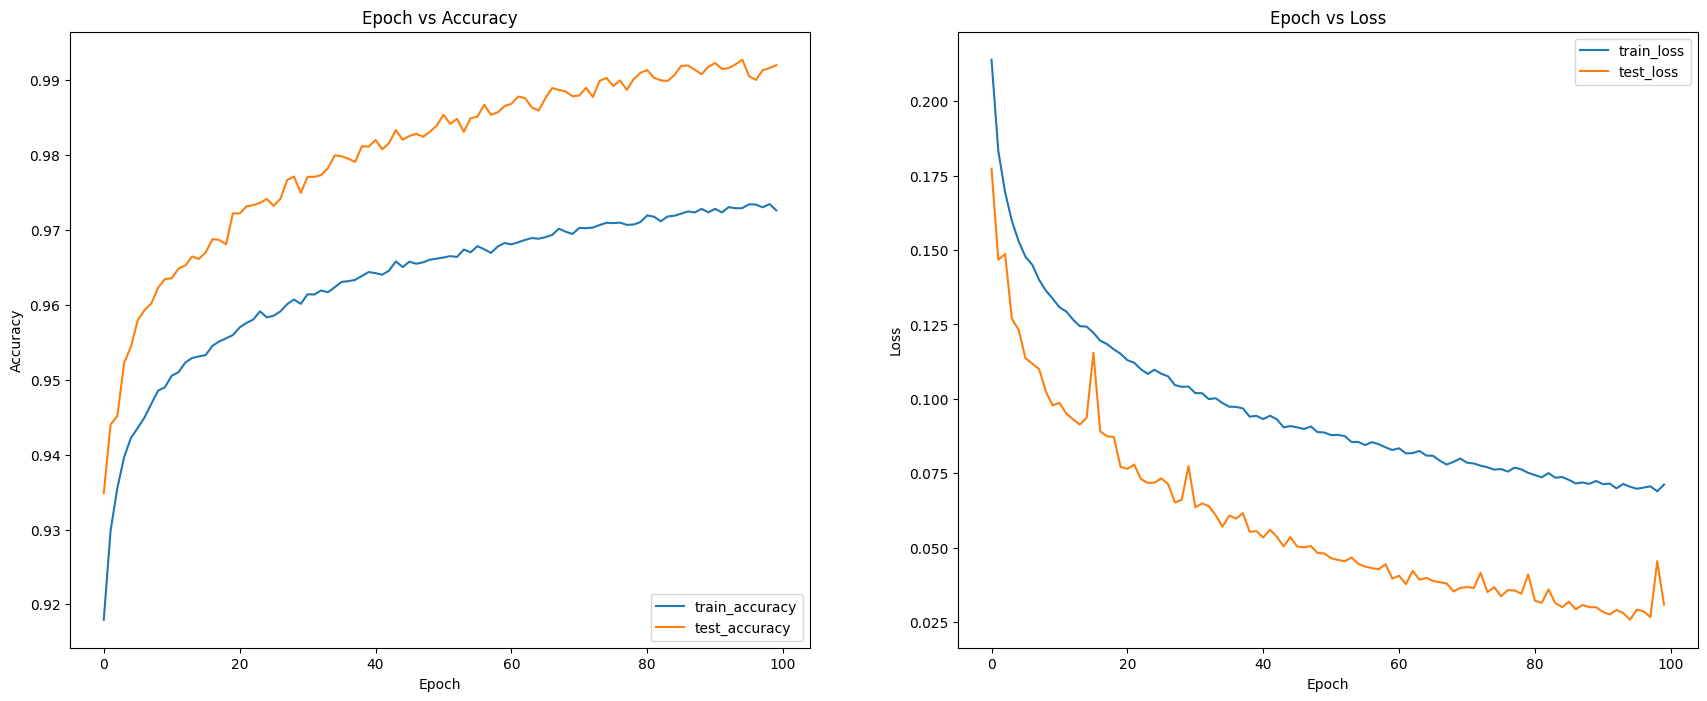

In [25]:

plt.figure(figsize=(21, 8))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='train_accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='test_accuracy')
plt.title("Epoch vs Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(cnn_history.history["loss"], label='train_loss')
plt.plot(cnn_history.history["val_loss"], label='test_loss')
plt.title("Epoch vs Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## LSTM

In [33]:

def lstm_model():
    model = Sequential()
    
    # First Bidirectional LSTM layer with return_sequences=True to maintain 3D output
    model.add(Conv1D(filters=32, kernel_size=3,padding='same',strides=1, activation='relu', input_shape=(1024, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))
    
    model.summary()
    return model


lstm_model=lstm_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 1024, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 512, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 512, 256)            │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,854,466 (129.14 MB)

 Trainable params: 33,853,378 (129.14 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [34]:




loss = tf.keras.losses.CategoricalCrossentropy()

lstm_model.compile(loss=loss,
              optimizer="adam",
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("lstm_model.keras", save_best_only=True, monitor='val_loss', verbose=1)

In [36]:


lstm_history=lstm_model.fit(train_ds,
                       epochs=3,
                       validation_data=val_ds,
                       callbacks=[callback,checkpoint],
                          verbose=1)

Epoch 1/3
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9254 - loss: 0.1921
Epoch 1: val_loss improved from inf to 0.14260, saving model to lstm_model.keras
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 306s 75ms/step - accuracy: 0.9254 - loss: 0.1921 - val_accuracy: 0.9464 - val_loss: 0.1426
Epoch 2/3
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9419 - loss: 0.1519
Epoch 2: val_loss improved from 0.14260 to 0.11423, saving model to lstm_model.keras
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 306s 75ms/step - accuracy: 0.9419 - loss: 0.1519 - val_accuracy: 0.9568 - val_loss: 0.1142
Epoch 3/3
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9512 - loss: 0.1302
Epoch 3: val_loss did not improve from 0.11423
4067/4067 ━━━━━━━━━━━━━━━━━━━━ 302s 74ms/step - accuracy: 0.9512 - loss: 0.1302 - val_accuracy: 0.9556 - val_loss: 0.1145
Restoring model weights from the end of the best epoch: 2.


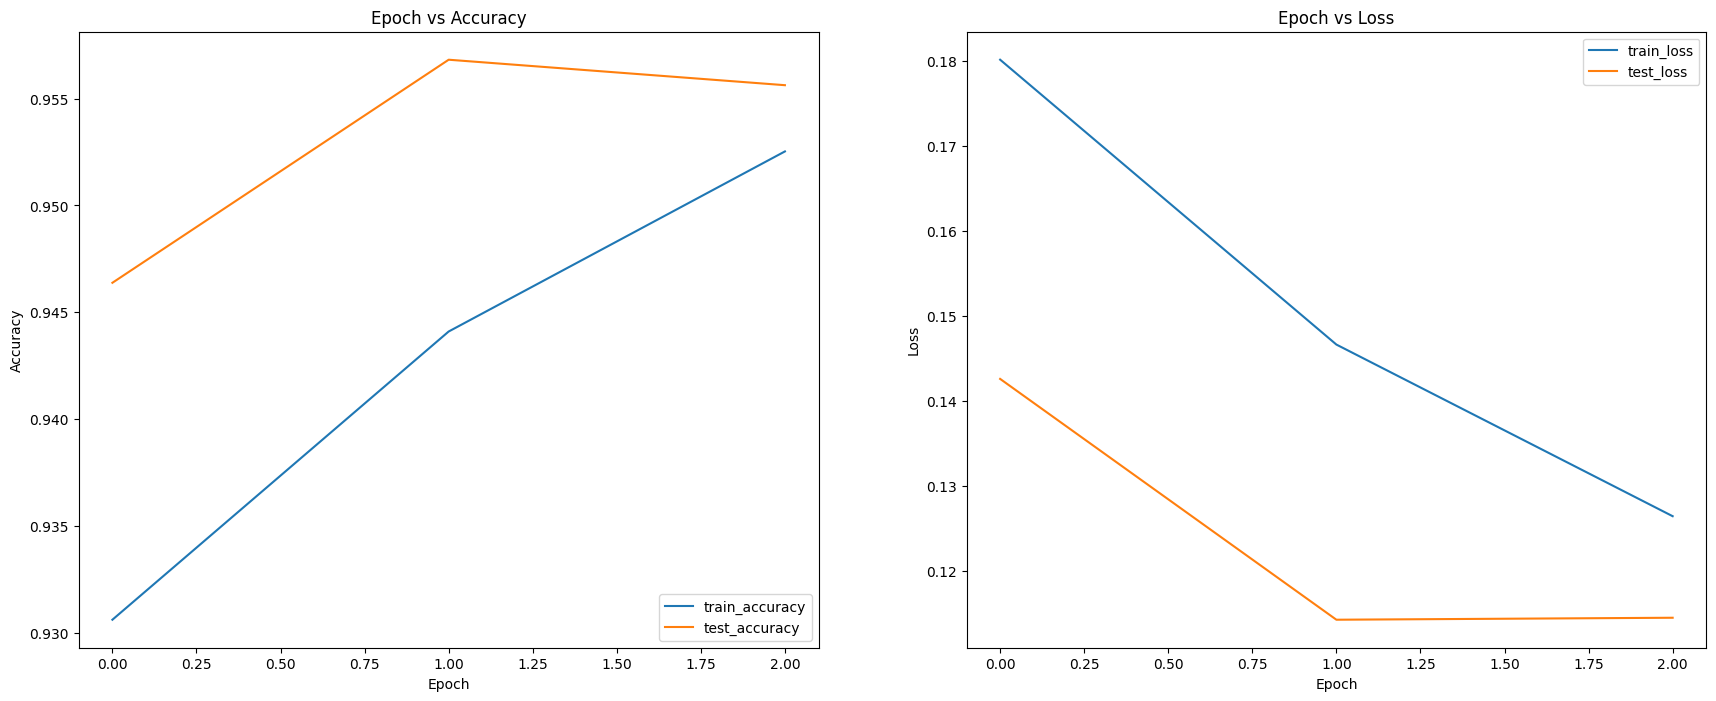

In [38]:

plt.figure(figsize=(21, 8))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='train_accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='test_accuracy')
plt.title("Epoch vs Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(lstm_history.history["loss"], label='train_loss')
plt.plot(lstm_history.history["val_loss"], label='test_loss')
plt.title("Epoch vs Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## Save Model

### ANN

In [16]:
class YamnetLayer(tf.keras.layers.Layer):
    def __init__(self, yamnet_model_handle, **kwargs):
        super(YamnetLayer, self).__init__(**kwargs)
        self.yamnet_layer = hub.KerasLayer(yamnet_model_handle, trainable=False)

    def call(self, inputs):
        return self.yamnet_layer(inputs)

class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


embedding_extraction_layer = YamnetLayer(yamnet_model_handle, name='yamnet',trainable=False)
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = ann_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
saved_model_path = './ann_human_or_bot'
serving_model.export(saved_model_path)

Saved artifact at './ann_human_or_bot'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.float32, name='audio')
Output Type:
  TensorSpec(shape=(2,), dtype=tf.float32, name=None)
Captures:
  137064667048144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137064667046736: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137064667047792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137064667047440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137064667047088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137064667046560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137064667045152: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137064667046208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137064667045856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137064667045504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137064667044976: TensorSpec(shap

### cnn

In [26]:


class YamnetLayer(tf.keras.layers.Layer):
    def __init__(self, yamnet_model_handle, **kwargs):
        super(YamnetLayer, self).__init__(**kwargs)
        self.yamnet_layer = hub.KerasLayer(yamnet_model_handle, trainable=False)

    def call(self, inputs):
        return self.yamnet_layer(inputs)

class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


# Define the custom layer
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis=-1, **kwargs):  # Default to adding the dimension at the last axis
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)


# Instantiate layers
embedding_extraction_layer = YamnetLayer(yamnet_model_handle, name='yamnet', trainable=False)
expand_dims_layer = ExpandDimsLayer(axis=-1, name='expand_dims')  # Add dimension at the last axis
reduce_mean_layer = ReduceMeanLayer(axis=0, name='classifier')

# Define the model
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')

# Pass input through layers
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
embeddings_output_expanded = expand_dims_layer(embeddings_output)  # Shape: (batch_size, 1024, 1)
serving_outputs = cnn_model(embeddings_output_expanded)
serving_outputs = reduce_mean_layer(serving_outputs)

# Build and save the final serving model
serving_model = tf.keras.Model(input_segment, serving_outputs)
saved_model_path = './cnn_human_or_bot'
serving_model.export(saved_model_path)


Saved artifact at './cnn_human_or_bot'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.float32, name='audio')
Output Type:
  TensorSpec(shape=(2,), dtype=tf.float32, name=None)
Captures:
  137063592029952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592028544: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137063592029600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592029248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592028896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592028368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592026960: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137063592028016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592027664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592027312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592026784: TensorSpec(shap

### LSTM

In [39]:


class YamnetLayer(tf.keras.layers.Layer):
    def __init__(self, yamnet_model_handle, **kwargs):
        super(YamnetLayer, self).__init__(**kwargs)
        self.yamnet_layer = hub.KerasLayer(yamnet_model_handle, trainable=False)

    def call(self, inputs):
        return self.yamnet_layer(inputs)

class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


# Define the custom layer
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis=-1, **kwargs):  # Default to adding the dimension at the last axis
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)


# Instantiate layers
embedding_extraction_layer = YamnetLayer(yamnet_model_handle, name='yamnet', trainable=False)
expand_dims_layer = ExpandDimsLayer(axis=-1, name='expand_dims')  # Add dimension at the last axis
reduce_mean_layer = ReduceMeanLayer(axis=0, name='classifier')

# Define the model
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')





# Pass input through layers
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
embeddings_output_expanded = expand_dims_layer(embeddings_output)  # Shape: (batch_size, 1024, 1)
serving_outputs = lstm_model(embeddings_output_expanded)
serving_outputs = reduce_mean_layer(serving_outputs)

# Build and save the final serving model
serving_model = tf.keras.Model(input_segment, serving_outputs)
saved_model_path = './lstm_human_or_bot'
serving_model.export(saved_model_path)


Saved artifact at './lstm_human_or_bot'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.float32, name='audio')
Output Type:
  TensorSpec(shape=(2,), dtype=tf.float32, name=None)
Captures:
  137063592029952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592028544: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137063592029600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592029248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592028896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592028368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592026960: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137063592028016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592027664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592027312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137063592026784: TensorSpec(sha

## Evaluation

In [41]:
#
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluation(model,test_ds,classes):
    predict_clas=[]
    real_clas=[]



    
    for inputs, labels in test_ds.take(1000):
        #print(inputs)
        #print(labels)
        # Expand dimensions to add batch size
        inputs = tf.expand_dims(inputs, axis=0)
        predict=model.predict(inputs)
        predict_clas.append(np.argmax(predict))
        real_clas.append(np.argmax(labels))
        
    # Generate classification report
    report = classification_report(real_clas,predict_clas, target_names=classes)
    print(report)

    # Compute confusion matrix
    cm = confusion_matrix(real_clas,predict_clas)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return real_clas , predict_clas,cm,report





### ANN model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

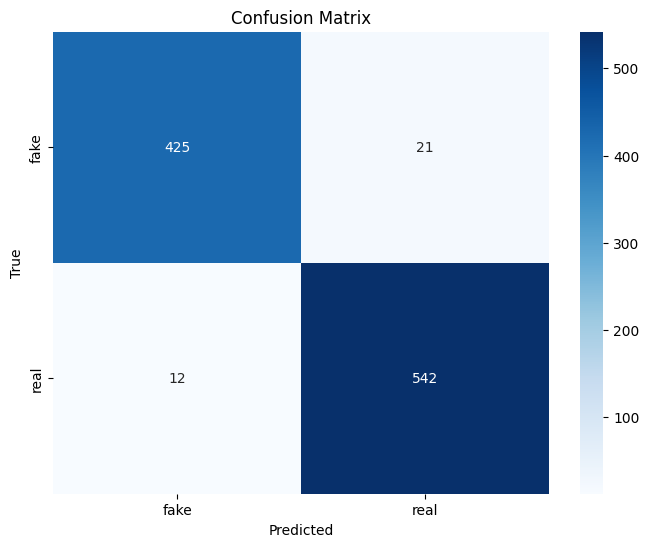

In [42]:

Real_labels,prdict_label,cm,report=evaluation(ann_model,test_ds,list(classes))




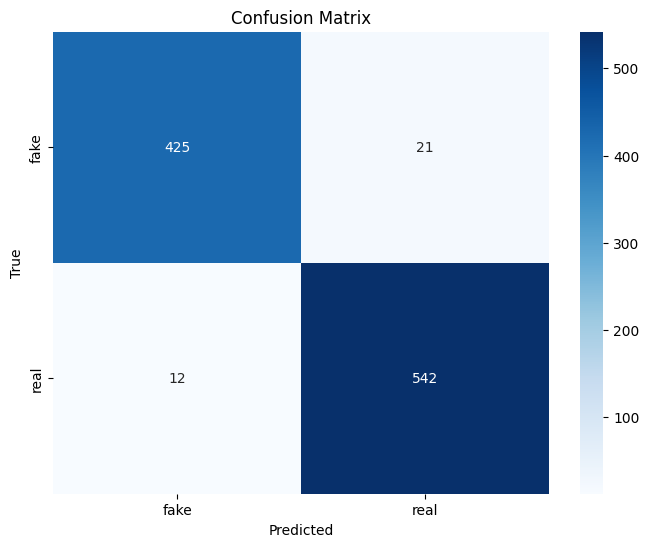

              precision    recall  f1-score   support

        fake       0.97      0.95      0.96       446
        real       0.96      0.98      0.97       554

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [43]:

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(classes), yticklabels=list(classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(report)

### CNN model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

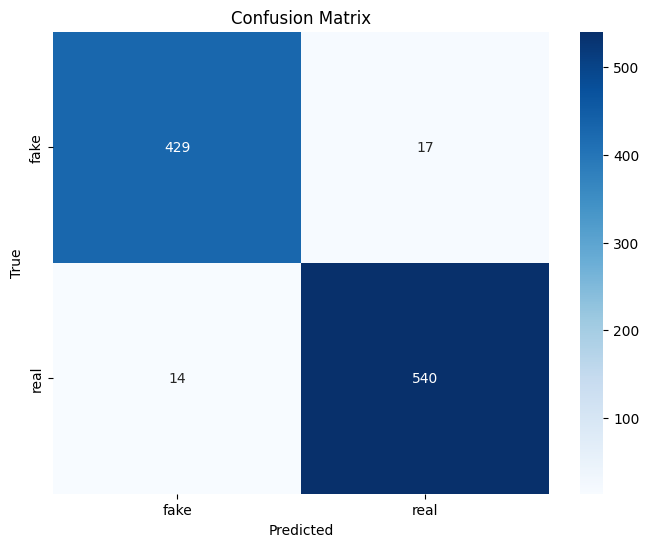

In [44]:

Real_labels2,prdict_label2,cm2,report2=evaluation(cnn_model,test_ds,list(classes))


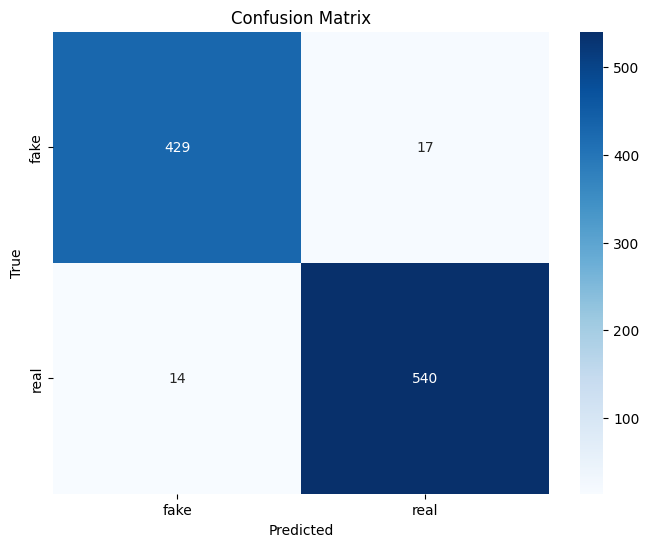

              precision    recall  f1-score   support

        fake       0.97      0.96      0.97       446
        real       0.97      0.97      0.97       554

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [45]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=list(classes), yticklabels=list(classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(report2)

### LSTM model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

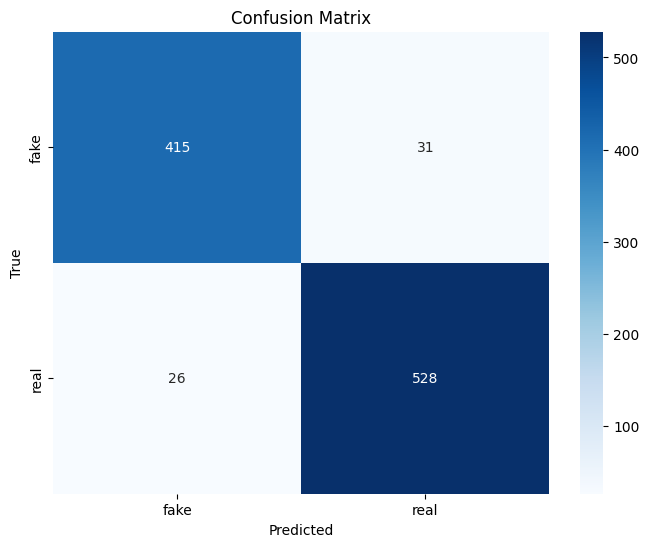

In [49]:

Real_labels3,prdict_label3,cm3,report3=evaluation(lstm_model,test_ds,list(classes))

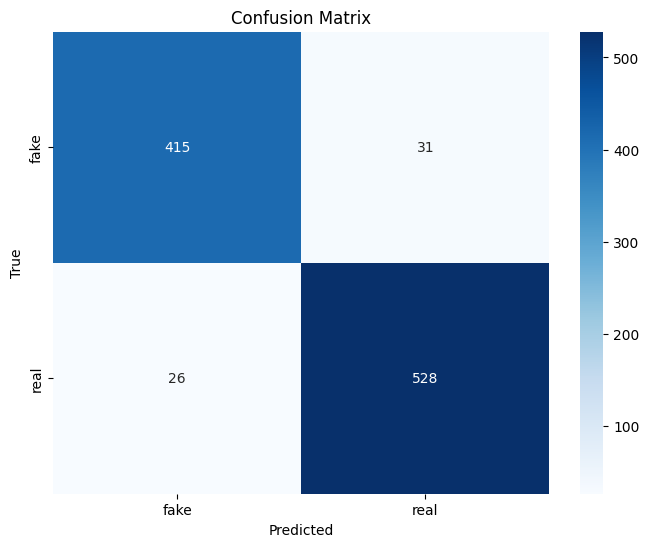

              precision    recall  f1-score   support

        fake       0.94      0.93      0.94       446
        real       0.94      0.95      0.95       554

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [50]:

plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=list(classes), yticklabels=list(classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(report3)

## inference

In [51]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    sound_sample,sr=librosa.load(filename ,sr=16000)
    return sound_sample

### Method 01

In [53]:

def infa_1(audio_path,model):
    testing_wav_data = load_wav_16k_mono(audio_path)
    
    scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
    results =model(embeddings)
    
    #print(results)
    
    my_classes=['FAKE', 'REAL']
    
    class_scores = tf.reduce_mean(results, axis=0)
    top_class = tf.math.argmax(class_scores)
    inferred_class = my_classes[top_class]
    
    
    print(class_scores)
    print(top_class)
    print(inferred_class)


In [58]:
##ANN model
audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake/10091.wav"
infa_1(audio_path,ann_model)

tf.Tensor([9.9996567e-01 3.4359247e-05], shape=(2,), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)
FAKE


In [59]:

audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real/10035.wav"
infa_1(audio_path,ann_model)

tf.Tensor([0.02785967 0.9721404 ], shape=(2,), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)
REAL


In [60]:
##CNN model
audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake/10091.wav"
infa_1(audio_path,cnn_model)

tf.Tensor([0.9882159 0.0117841], shape=(2,), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)
FAKE


In [61]:

audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real/10035.wav"
infa_1(audio_path,cnn_model)

tf.Tensor([0.00871396 0.99128604], shape=(2,), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)
REAL


In [62]:
##LSTM model
audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake/10091.wav"
infa_1(audio_path,lstm_model)

tf.Tensor([0.9885261  0.01147379], shape=(2,), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)
FAKE


In [63]:
audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real/10035.wav"
infa_1(audio_path,lstm_model)

tf.Tensor([0.05442897 0.945571  ], shape=(2,), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)
REAL


### Method 2

In [65]:

def infa_2(audio_path,model_path):
    testing_wav_data = load_wav_16k_mono(audio_path)
    
    # Reload the model
    reloaded_model = tf.saved_model.load(model_path)
    
    # If it's a saved model, access the signature
    infer = reloaded_model.signatures['serving_default']
    
    # Now use the model for prediction, passing in the necessary inputs (e.g., audio data)
    # Make sure 'testing_wav_data' is prepared in the required shape/format
    input_tensor = tf.convert_to_tensor(testing_wav_data, dtype=tf.float32)
    
    # Get the prediction output
    output = infer(input_tensor)
    predictions = output['output_0']  # Adjust 'output_0' based on your model's output signature
    
    print(predictions)
    my_classes=['FAKE', 'REAL']
    
    human_bot = my_classes[tf.math.argmax(predictions)]
    print(f'The main sound is: {human_bot}')

In [66]:
##Ann model
audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake/10091.wav"
model_path="/kaggle/working/ann_human_or_bot"
infa_2(audio_path,model_path)

tf.Tensor([9.9996567e-01 3.4359247e-05], shape=(2,), dtype=float32)
The main sound is: FAKE


In [67]:

audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real/10035.wav"
model_path="/kaggle/working/ann_human_or_bot"
infa_2(audio_path,model_path)

tf.Tensor([0.02785967 0.9721404 ], shape=(2,), dtype=float32)
The main sound is: REAL


In [68]:
##Cnn model 
audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake/10091.wav"
model_path="/kaggle/working/cnn_human_or_bot"
infa_2(audio_path,model_path)

tf.Tensor([0.9882159 0.0117841], shape=(2,), dtype=float32)
The main sound is: FAKE


In [69]:

audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real/10035.wav"
model_path="/kaggle/working/cnn_human_or_bot"
infa_2(audio_path,model_path)

tf.Tensor([0.00871396 0.99128604], shape=(2,), dtype=float32)
The main sound is: REAL


In [70]:
##Lstm model
audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake/10091.wav"
model_path="/kaggle/working/lstm_human_or_bot"
infa_2(audio_path,model_path)

tf.Tensor([0.9885261  0.01147379], shape=(2,), dtype=float32)
The main sound is: FAKE


In [71]:
audio_path="/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real/10035.wav"
model_path="/kaggle/working/lstm_human_or_bot"
infa_2(audio_path,model_path)

tf.Tensor([0.05442897 0.945571  ], shape=(2,), dtype=float32)
The main sound is: REAL


## Zip the files

In [20]:


import zipfile
import os

def zip_folder(folder_path, zip_name):
    # Ensure the folder path exists
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return
    
    # Create a ZipFile object
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        # Iterate over all the files in the folder
        for root, _, files in os.walk(folder_path):
            for file in files:
                # Write each file into the ZIP file
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

    print(f"Folder '{folder_path}' zipped successfully as '{zip_name}'.")




In [27]:
# Example usage:
folder_to_zip = '/kaggle/working/cnn_human_or_bot'
zip_name = 'cnn_human_or_bot.zip'

zip_folder(folder_to_zip, zip_name)

Folder '/kaggle/working/cnn_human_or_bot' zipped successfully as 'cnn_human_or_bot.zip'.
